In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install sklearn
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head(20)

,Winner,First_pokemon,Second_pokemon
0,124,124,221
1,1,323,1
2,58,58,459
3,491,180,491
4,799,799,559
5,70,61,70
6,773,773,180
7,181,437,181
8,285,285,485
9,678,452,678


## ESPLORAZIONE BASICA DEL DATASET COMBATS PER VISUALIZZARE VALORI NULLI, VALORI RIPETUTI 

In [4]:
feature = list(train)
print(feature)

['Winner', 'First_pokemon', 'Second_pokemon']


In [5]:
for c in train.columns:   
    print ("Features: ", c)
    print(train[c].value_counts())
    print("\n-------\n")

for c in test.columns:   
    print ("Features: ", c)
    print(test[c].value_counts())
    print("\n-------\n") 

Features:  Winner
163    111
155     89
428     88
427     88
164     87
      ... 
176      3
290      3
237      2
577      2
190      2
Name: Winner, Length: 783, dtype: int64

-------

Features:  First_pokemon
163    68
71     63
344    59
559    58
667    58
       ..
757    27
509    24
34     24
666    24
458    21
Name: First_pokemon, Length: 784, dtype: int64

-------

Features:  Second_pokemon
36     62
225    58
214    57
338    56
360    56
       ..
795    26
274    24
156    23
421    22
519    20
Name: Second_pokemon, Length: 784, dtype: int64

-------

Features:  Winner
154    29
432    29
544    28
59     27
426    27
       ..
577     1
510     1
374     1
14      1
189     1
Name: Winner, Length: 768, dtype: int64

-------

Features:  First_pokemon
544    23
453    20
791    19
764    19
593    19
       ..
5       3
566     3
653     3
650     2
172     2
Name: First_pokemon, Length: 784, dtype: int64

-------

Features:  Second_pokemon
502    22
680    21
246    21

#### OSSERVAZIONI:

##### * Utile stampare una rapida distribuzione, tuttavia analisi piu' accurate verranno fatte nella successiva sezione di Analisi Dei Dati

In [6]:
print(train.isnull().sum()) #valori nulli in train
print(test.isnull().sum())  #valori nulli in test

Winner            0
First_pokemon     0
Second_pokemon    0
dtype: int64
Winner            0
First_pokemon     0
Second_pokemon    0
dtype: int64


#### OSSERVAZIONI:

##### * Non ci sono valori nulli nei dataset train e test derivanti dal file "combats.csv"

In [7]:
train.info() #controllo i dtype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Winner          32000 non-null  int64
 1   First_pokemon   32000 non-null  int64
 2   Second_pokemon  32000 non-null  int64
dtypes: int64(3)
memory usage: 750.1 KB


### TRASFORMO IL VALORE DI WINNER IN BINARIO, CIO' SERVIRA' SUCCESSIVAMENTE IN FASE DI CLASSIFICAZIONE

In [8]:
def binary_winner(winner, first_pokemon, second_pokemon):
    if (first_pokemon == winner):
        return 0
    elif (second_pokemon == winner):
        return 1
    
train['Winner']= train.apply(lambda x: binary_winner(x['Winner'], x['First_pokemon'], x['Second_pokemon']), axis=1)
test['Winner']= test.apply(lambda x: binary_winner(x['Winner'], x['First_pokemon'], x['Second_pokemon']), axis=1)

In [9]:
train.head(15)

,Winner,First_pokemon,Second_pokemon
0,0,124,221
1,1,323,1
2,0,58,459
3,1,180,491
4,0,799,559
5,1,61,70
6,0,773,180
7,1,437,181
8,0,285,485
9,1,452,678


## ESPLORAZIONE BASICA DEL DATASET POKEMON

In [10]:
pokemonData = pd.read_csv('pokemon.csv')

In [11]:
pokemonData.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [12]:
featurePokemon = list(pokemonData)
print(featurePokemon)

['#', 'Name', 'Type 1', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary']


In [13]:
for c in train.columns:   
    print ("Features: ", c)
    print(train[c].value_counts())
    print("\n-------\n")


Features:  Winner
1    16916
0    15084
Name: Winner, dtype: int64

-------

Features:  First_pokemon
163    68
71     63
344    59
559    58
667    58
       ..
757    27
509    24
34     24
666    24
458    21
Name: First_pokemon, Length: 784, dtype: int64

-------

Features:  Second_pokemon
36     62
225    58
214    57
338    56
360    56
       ..
795    26
274    24
156    23
421    22
519    20
Name: Second_pokemon, Length: 784, dtype: int64

-------



#### OSSERVAZIONI:

##### * Utile stampare una rapida distribuzione, tuttavia analisi piu' accurate verranno fatte nella successiva sezione di Analisi Dei Dati

In [14]:
print(pokemonData.isnull().sum()) #controllo i valori nulli

#               0
Name            1
Type 1          0
Type 2        386
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64


#### OSSERVAZIONI

##### * Valori nulli di type2 dovranno essere gestiti in seguito

In [15]:
pokemonData.info() #controllo i dtype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        799 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   HP          800 non-null    int64 
 5   Attack      800 non-null    int64 
 6   Defense     800 non-null    int64 
 7   Sp. Atk     800 non-null    int64 
 8   Sp. Def     800 non-null    int64 
 9   Speed       800 non-null    int64 
 10  Generation  800 non-null    int64 
 11  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB


## EFFETTUO IL JOIN TRA IL POKEMONDATA E IL TRAIN & TEST

In [16]:
joinedTrain = train.join(pokemonData.set_index('#'), on="First_pokemon", rsuffix="_first")
train = joinedTrain.join(pokemonData.set_index('#'), on="Second_pokemon", rsuffix="_second")
joinedTest = test.join(pokemonData.set_index('#'), on="First_pokemon", rsuffix="_first")
test = joinedTest.join(pokemonData.set_index('#'), on="Second_pokemon", rsuffix="_second")

train.head() #visualizzo rapidamente il join compiuto

,Winner,First_pokemon,Second_pokemon,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,...,Type 1_second,Type 2_second,HP_second,Attack_second,Defense_second,Sp. Atk_second,Sp. Def_second,Speed_second,Generation_second,Legendary_second
0,0,124,221,Kangaskhan,Normal,NaN,105,95,80,40,...,Bug,Steel,75,90,140,60,60,40,2,False
1,1,323,1,Azurill,Normal,Fairy,50,20,40,20,...,Grass,Poison,45,49,49,65,65,45,1,False
2,0,58,459,Meowth,Normal,NaN,40,45,35,40,...,Bug,Grass,60,59,85,79,105,36,4,False
3,1,180,491,Ledyba,Bug,Flying,40,20,30,40,...,Ghost,Dark,50,92,108,92,108,35,4,False
4,0,799,559,Hoopa Unbound,Psychic,Dark,80,160,60,170,...,Fire,Fighting,90,93,55,70,55,55,5,False


## ANALISI DEI DATI SUL DATASET JOINED

In [17]:
print(train.isnull().sum()) #controllo i valori nulli dopo il join
print("\n-----------------SEPARATOR---------------\n")
print(test.isnull().sum()) #controllo i valori nulli dopo il join

Winner                   0
First_pokemon            0
Second_pokemon           0
Name                    35
Type 1                   0
Type 2               15424
HP                       0
Attack                   0
Defense                  0
Sp. Atk                  0
Sp. Def                  0
Speed                    0
Generation               0
Legendary                0
Name_second             33
Type 1_second            0
Type 2_second        15359
HP_second                0
Attack_second            0
Defense_second           0
Sp. Atk_second           0
Sp. Def_second           0
Speed_second             0
Generation_second        0
Legendary_second         0
dtype: int64

-----------------SEPARATOR---------------

Winner                  0
First_pokemon           0
Second_pokemon          0
Name                   10
Type 1                  0
Type 2               3840
HP                      0
Attack                  0
Defense                 0
Sp. Atk                 0
Sp. Def 

#### OSSERVAZIONI:

##### * Gestiro' successivamente i valori nulli di type2 eliminando la colonna dato che 15mila valori nulli sono troppi per pensare di eliminare solo determinate righe 

##### * Per quanto riguarda i nomi dei Pokemon ci sono 10 valori nulli per i quali posso droppare direttamente le righe. Tuttavia i nomi dei Pokemon sono irrilevanti ai fini della classificazione stessa e per questo eliminero' direttamente tutta la colonna

In [18]:
train.info() #stampo i DType

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Winner             32000 non-null  int64 
 1   First_pokemon      32000 non-null  int64 
 2   Second_pokemon     32000 non-null  int64 
 3   Name               31965 non-null  object
 4   Type 1             32000 non-null  object
 5   Type 2             16576 non-null  object
 6   HP                 32000 non-null  int64 
 7   Attack             32000 non-null  int64 
 8   Defense            32000 non-null  int64 
 9   Sp. Atk            32000 non-null  int64 
 10  Sp. Def            32000 non-null  int64 
 11  Speed              32000 non-null  int64 
 12  Generation         32000 non-null  int64 
 13  Legendary          32000 non-null  bool  
 14  Name_second        31967 non-null  object
 15  Type 1_second      32000 non-null  object
 16  Type 2_second      16641 non-null  objec

### EFFETTUO UN RAPIDO PREPROCESSING SULLE COLONNE CHE GIA' SI POSSONO ELIMINARE PER SCARSA RILEVANZA (NOME) E PER ECCESSO DI VALORI NULLI (TYPE 2)

In [19]:
toDrop = ['Name','Name_second', 'Type 2', 'Type 2_second']
train = train.drop(toDrop, axis=1)
test = test.drop(toDrop, axis=1)

train.head()

,Winner,First_pokemon,Second_pokemon,Type 1,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,...,Legendary,Type 1_second,HP_second,Attack_second,Defense_second,Sp. Atk_second,Sp. Def_second,Speed_second,Generation_second,Legendary_second
0,0,124,221,Normal,105,95,80,40,80,90,...,False,Bug,75,90,140,60,60,40,2,False
1,1,323,1,Normal,50,20,40,20,40,20,...,False,Grass,45,49,49,65,65,45,1,False
2,0,58,459,Normal,40,45,35,40,40,90,...,False,Bug,60,59,85,79,105,36,4,False
3,1,180,491,Bug,40,20,30,40,80,55,...,False,Ghost,50,92,108,92,108,35,4,False
4,0,799,559,Psychic,80,160,60,170,130,80,...,True,Fire,90,93,55,70,55,55,5,False


In [20]:
toEncode = ['Type 1','Legendary', 'Type 1_second', 'Legendary_second']

encoder = LabelEncoder()
for element in toEncode:
    train[element] = encoder.fit_transform(train[element])
    test[element] = encoder.fit_transform(test[element])

train.head()

,Winner,First_pokemon,Second_pokemon,Type 1,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,...,Legendary,Type 1_second,HP_second,Attack_second,Defense_second,Sp. Atk_second,Sp. Def_second,Speed_second,Generation_second,Legendary_second
0,0,124,221,12,105,95,80,40,80,90,...,0,0,75,90,140,60,60,40,2,0
1,1,323,1,12,50,20,40,20,40,20,...,0,9,45,49,49,65,65,45,1,0
2,0,58,459,12,40,45,35,40,40,90,...,0,0,60,59,85,79,105,36,4,0
3,1,180,491,0,40,20,30,40,80,55,...,0,8,50,92,108,92,108,35,4,0
4,0,799,559,14,80,160,60,170,130,80,...,1,6,90,93,55,70,55,55,5,0


### CONTROLLO LA DISTRIBUZIONE DEI VALORI E LA HEATMAP

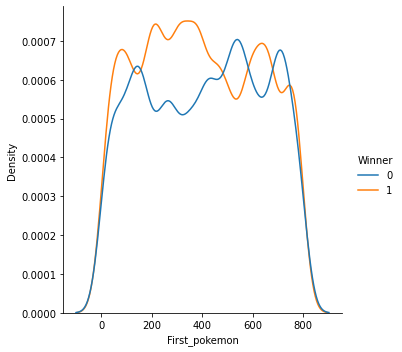

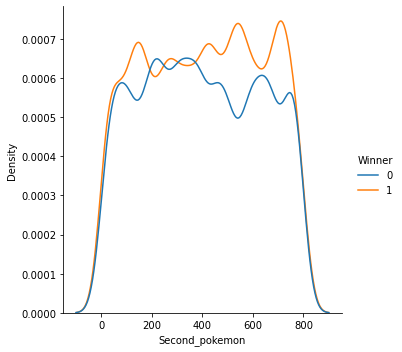

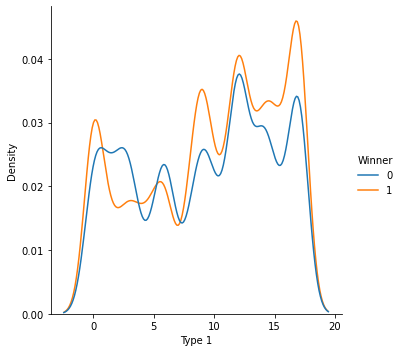

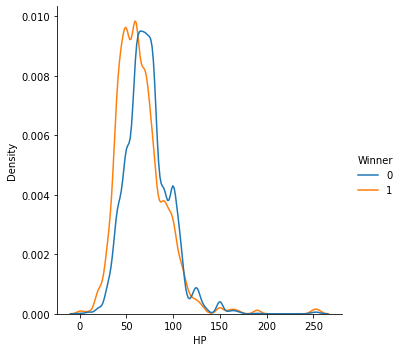

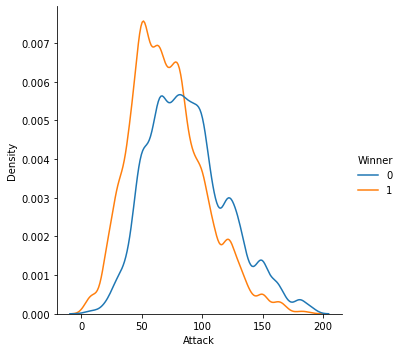

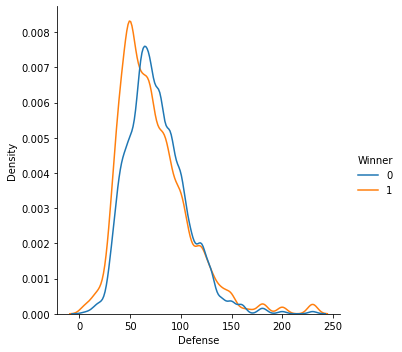

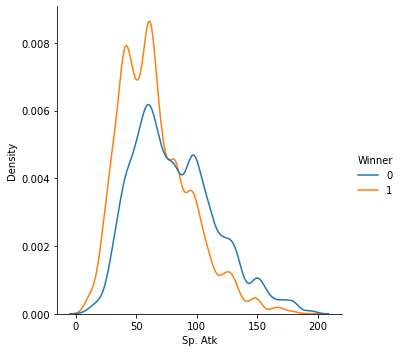

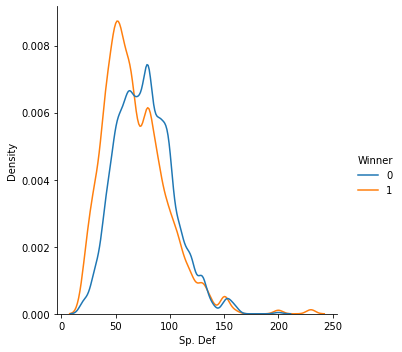

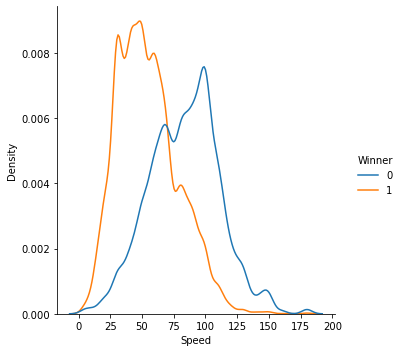

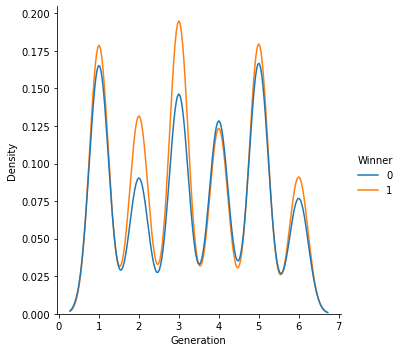

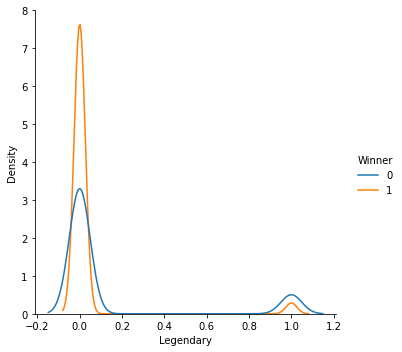

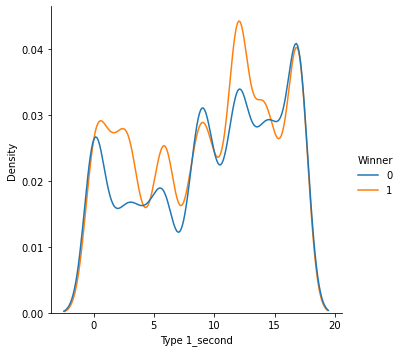

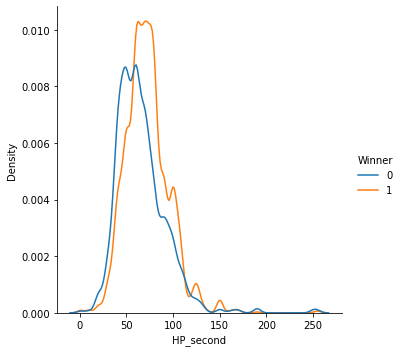

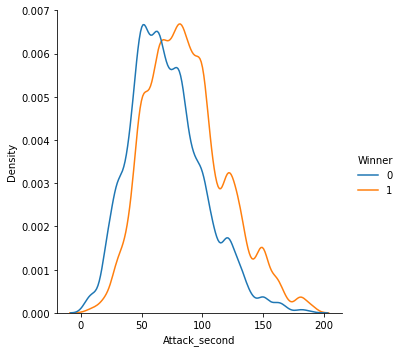

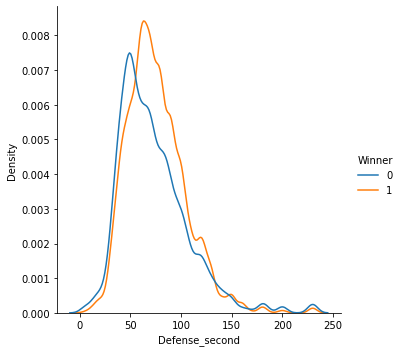

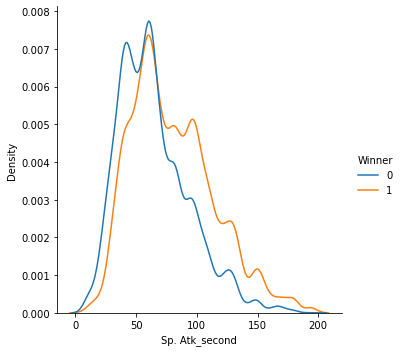

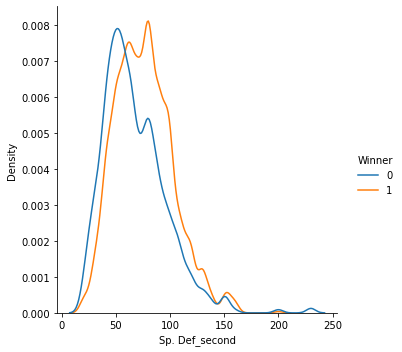

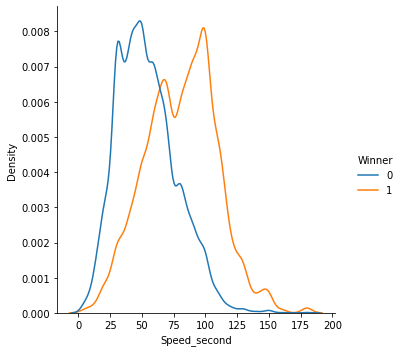

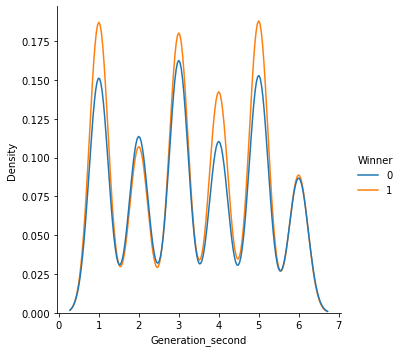

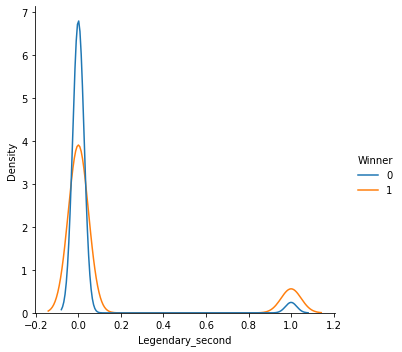

In [21]:
feature = list(train)
feature.remove('Winner')

for feature in feature:
    g = sns.displot(data=train, x=feature, hue=train['Winner'], kind="kde", facet_kws=dict(sharey=False, sharex=False))  
    plt.show()
    

#### OSSERVAZIONI:

##### * Possibile constatare dal grado di sovrapposizione della distribuzione dei valori winner che alcune feature sono completamente superflue alla classificazione, ad esempio generation, first_pokemon, second_pokemon, type 1, type 1_second

##### * Possibile constatare che alcune feature relative alle stats dei pokemon possiedono valori interessanti da quanto si osserva dalla distribuzione dei valori su winner, probabilmente e' possibile ricavare nuove feature computando la differenza tra le stats (ad esempio Attack, Defense, Sp. Attack, Sp. Defense, Speed ecc..). Lo provero' in seguito

<AxesSubplot:>

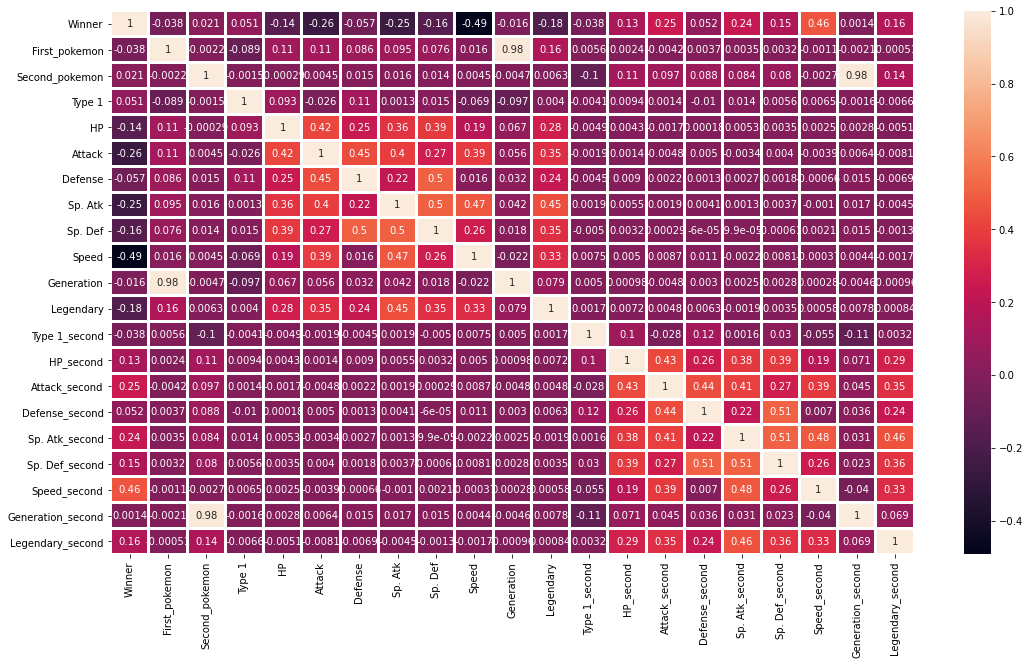

In [22]:
plt.figure(figsize=(18,10))
correlation = train.corr()
sns.heatmap(correlation, annot = True, linewidth = 2) #IN ALTERNATIVA POTEVO USARE BARPLOT E PANDA CORR

#### OSSERVAZIONI:

##### * La heatmap sostanzialmente conferma l'inutilita' dei valori generation, first_pokemon, second_pokemon, type 1 per entrambi i Pokemon dello scontro. Verranno sicuramente droppate in uno dei passaggi successivi

##### * Ora e' necessario verificare se l'aggiunta delle feature ipotizzate aggiunge informazione utile al fine della classifcazione

### SICCOME LE STATS SONO VALORI INTERI, POSSO PROVARE A VEDERE SE COMPUTARE LA DIFFERENZA TRA LE STATS DEI DUE POKEMON CI DA QUALCHE POSSIBILE VANTAGGIO NELLE HEATMAP

In [23]:
##Aggiungo delle stats ulteriori
train['HP_Difference'] = train['HP'] - train['HP_second']
test['HP_Difference'] = test['HP'] - test['HP_second']
train['Attack_Difference'] = train['Attack'] - train['Attack_second']
test['Attack_Difference'] = test['Attack'] - test['Attack_second']
train['Defense_Difference'] = train['Defense'] - train['Defense_second']
test['Defense_Difference'] = test['Defense'] - test['Defense_second'] 
train['Sp. Atk_Difference'] = train['Sp. Atk'] - train['Sp. Atk_second']
test['Sp. Atk_Difference'] = test['Sp. Atk'] - test['Sp. Atk_second']
train['Sp. Def_Difference'] = train['Sp. Def'] - train['Sp. Def_second']
test['Sp. Def_Difference'] = test['Sp. Def'] - test['Sp. Def_second']
train['Speed_Difference'] = train['Speed'] - train['Speed_second']
test['Speed_Difference'] = test['Speed'] - test['Speed_second']

<Figure size 1800x720 with 0 Axes>

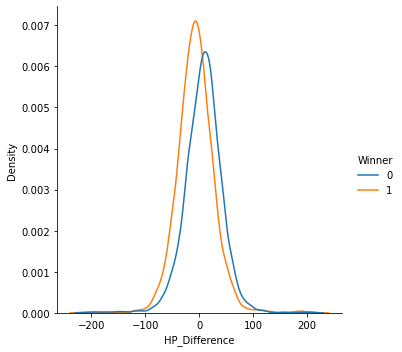

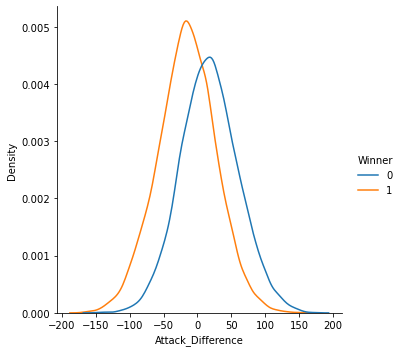

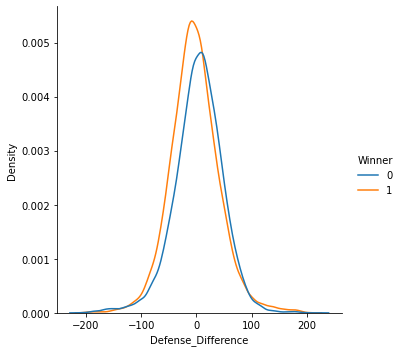

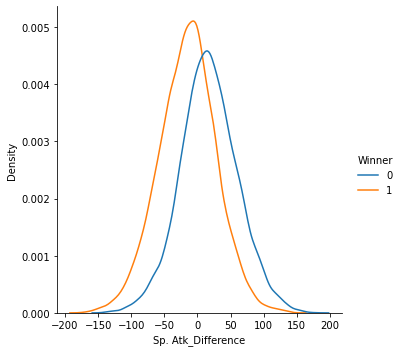

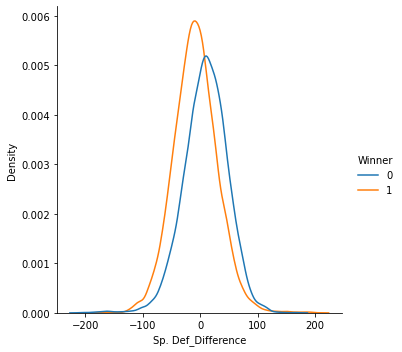

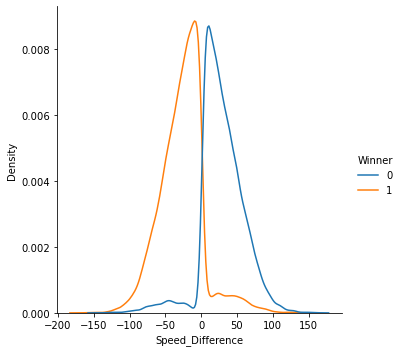

In [24]:
newFeature = ['HP_Difference', 'Attack_Difference', 'Defense_Difference', 'Sp. Atk_Difference', 'Sp. Def_Difference', 'Speed_Difference']

plt.figure(figsize=(25,10))
for feature in newFeature:
    g = sns.displot(data=train, x=feature, hue=train['Winner'], kind="kde", facet_kws=dict(sharey=False, sharex=False))  
    plt.show()

### OSSERVAZIONI

##### * Queste nuove feature sembrano essere molto promettenti ad eccezione di Defense_Difference che e' troppo sovrapposta e "meno netta" nei valori di Winner, per confermare cio' e' possibile anche utilizzare una nuova heatmap

<AxesSubplot:>

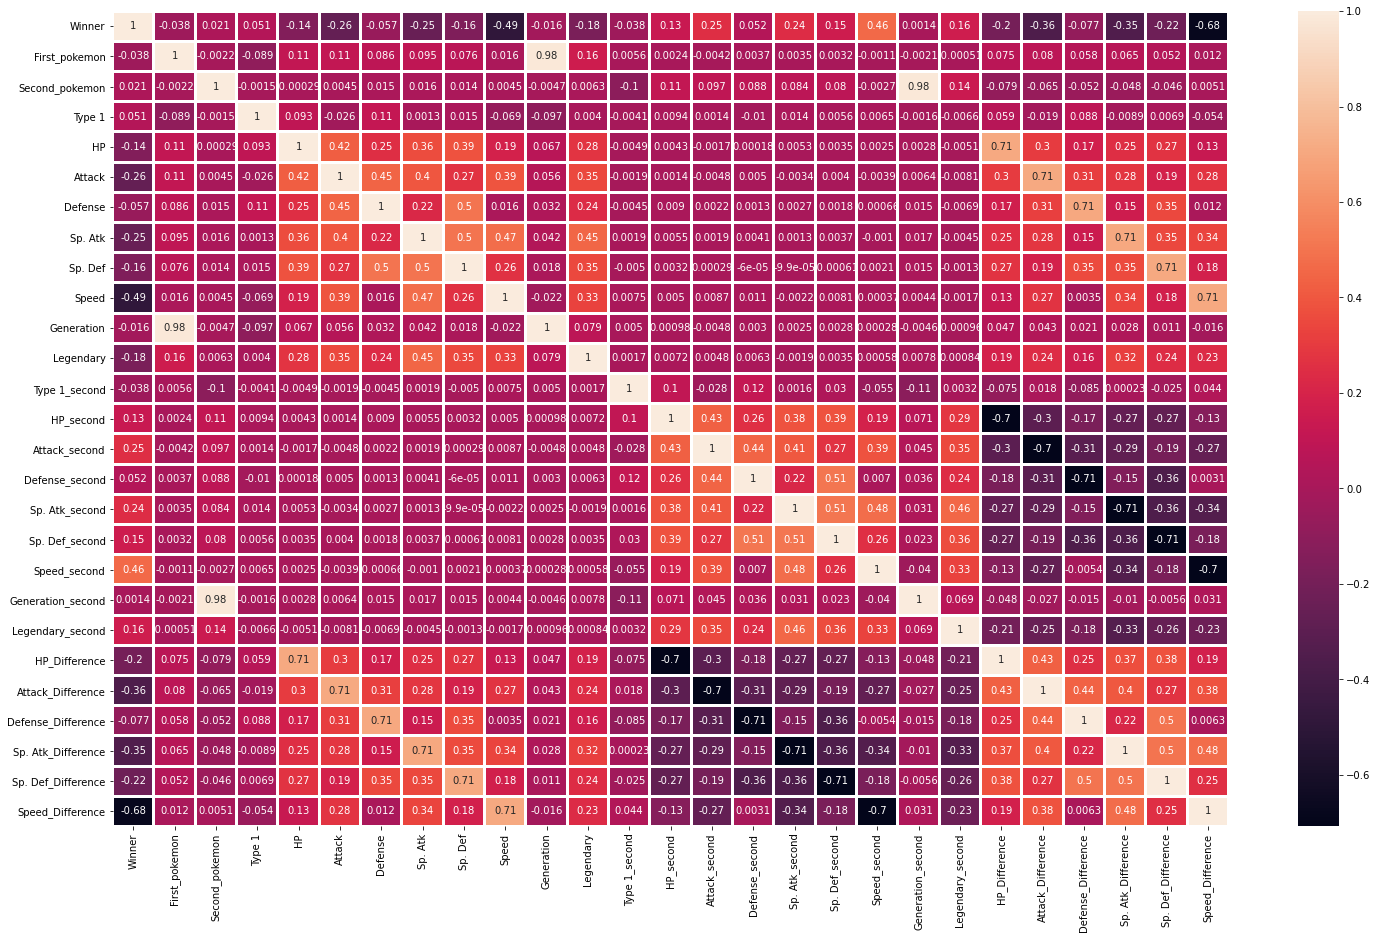

In [25]:
plt.figure(figsize=(25,15))
correlation = train.corr()
sns.heatmap(correlation, annot = True, linewidth = 2)

#ANALIZZO PRINCIPALMENTE I CORRELATI A WINNER, INDIVIDUO VALORI POCO SIGNIFICATIVI CHE SONO QUELLI NELL'INTORNO DI 0:
#First_Pokemon, Second_pokemon, Type 1, Defense, Generation, Type 1_second, Defense_second, Generation_second, Defense_Difference

### OSSERVAZIONI:

##### * La heatmap conferma la scarsa rilevanza di Defense_Difference

##### * Le feature scartabili a seguito dell'analisi risultano essere: First_Pokemon, Second_pokemon, Type 1, Defense, Generation, Type 1_second, Defense_second, Generation_second, Defense_Difference

##### * Computare la differenza delle stats ha aiutato nella maggior parte dei casi con l'unica eccezione di Defense_Difference che continua ad avere una correlazione molto bassa

### SECONDO DROP DI VALORI POCO SIGNIFICATIVI

##### Possibile eliminare i seguenti valori per la bassa correlazione verificata in precedenza

In [26]:
#Droppo i valori poco significativi analizzati in precedenza
toDrop = ['First_pokemon', 'Second_pokemon', 'Type 1', 'Defense', 'Generation', 'Type 1_second', 'Defense_second', 'Generation_second', 'Defense_Difference']
train = train.drop(toDrop, axis=1)
test = test.drop(toDrop, axis=1)

train.head()

,Winner,HP,Attack,Sp. Atk,Sp. Def,Speed,Legendary,HP_second,Attack_second,Sp. Atk_second,Sp. Def_second,Speed_second,Legendary_second,HP_Difference,Attack_Difference,Sp. Atk_Difference,Sp. Def_Difference,Speed_Difference
0,0,105,95,40,80,90,0,75,90,60,60,40,0,30,5,-20,20,50
1,1,50,20,20,40,20,0,45,49,65,65,45,0,5,-29,-45,-25,-25
2,0,40,45,40,40,90,0,60,59,79,105,36,0,-20,-14,-39,-65,54
3,1,40,20,40,80,55,0,50,92,92,108,35,0,-10,-72,-52,-28,20
4,0,80,160,170,130,80,1,90,93,70,55,55,0,-10,67,100,75,25


# DEFINISCO LA PARTE DI TRAINING DEL MODELLO

In [27]:
y_train = train['Winner']          
X_train = train.drop(['Winner'], axis=1)  

y_test = test['Winner']          
X_test = test.drop(['Winner'], axis=1)

DecisionTreeClassifier()
92.26


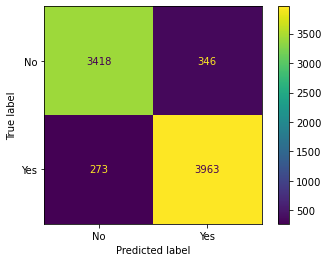



              precision    recall  f1-score   support

           0       0.93      0.91      0.92      3764
           1       0.92      0.94      0.93      4236

    accuracy                           0.92      8000
   macro avg       0.92      0.92      0.92      8000
weighted avg       0.92      0.92      0.92      8000

RandomForestClassifier()
95.41


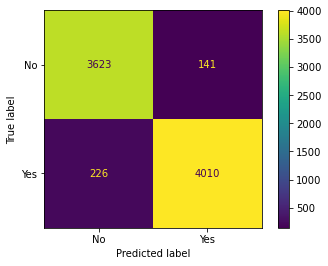



              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3764
           1       0.97      0.95      0.96      4236

    accuracy                           0.95      8000
   macro avg       0.95      0.95      0.95      8000
weighted avg       0.95      0.95      0.95      8000



,Model,Score
1,Random Forest,95.41
0,Decision Tree,92.26


In [28]:
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

models = [dt, rf]
score = []

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = round(accuracy_score(y_pred, y_test) * 100, 2)
    score.append(acc)
    print(model)
    print(acc)
    plot_confusion_matrix(model, X_test, y_test, values_format='n', display_labels=['No','Yes']) 
    plt.show()
    print("\n")
    print(classification_report(y_test,y_pred))
    
models = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest'],
    'Score': score})
models.sort_values(by='Score', ascending=False)

## OSSERVAZIONI CONCLUSIVE

#### * Random Forest: Anche se non spiegato a lezione, si tratta di un algoritmo che genera una moltitudine di decision tree. Ogni singolo albero nella foresta genera una previsione. Al termine si sceglie la classe di previsione che e' stata predetta per la maggiore tra gli alberi appartenenti alla foresta. Generalmente questo sistema "a maggioranza" risulta piu' performante del singolo decision tree

#### * Random Forest decisamente piu' performante sia del Decision Tree (come ci aspettavamo) di conseguenza e' l'algoritmo migliore per la classificazione

#### * Ho effettuato una rapida prova togliendo le feature "difference" aggiunte nella sezione di Analisi Di Dati ed ho constatato che un loro utilizzo migliora complessivamente il modello di classifcazione di 1 punto di Score

#### * Nel caso in cui non accettasse il Random Forest dato che non e' stato trattato a lezione, le ho lasciato anche il Decision Tree